This jupyter notebook contains demo code for:
- loading a model and using it to 
- drive one or more source frames with a set of driving frames
- modifying the embedded face to perform video editing for both the dragon tattoo and Harry Potter scar

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import os
import torch
from PIL import Image
from torch.autograd import Variable
from UnwrappedFace import UnwrappedFaceWeightedAverage, UnwrappedFaceWeightedAveragePose
import torchvision
from torchvision.transforms import ToTensor, Compose, Scale

import warnings
warnings.filterwarnings('ignore')

In [2]:
def run_batch(source_images, pose_images, requires_grad=False, volatile=False):
    return model(pose_images, *source_images)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from functools import partial
import pickle
import sys

pickle.load = partial(pickle.load, encoding="latin1")
pickle.Unpickler = partial(pickle.Unpickler, encoding="latin1")

def torch_load_model(path):
    if sys.version_info[0] < 3:
        if torch.cuda.is_available():
            state_dict = torch.load(path)
        else:
            state_dict = torch.load(path, map_location='cpu')
    else:
        if torch.cuda.is_available():
            state_dict = torch.load(path, pickle_module=pickle)
        else:
            state_dict = torch.load(path, map_location='cpu', pickle_module=pickle)
    return state_dict

In [5]:
BASE_MODEL = 'release_models/' # Change to your path
state_dict = torch_load_model(BASE_MODEL + 'x2face_model.pth')

model = UnwrappedFaceWeightedAverage(output_num_channels=2, input_num_channels=3, inner_nc=128)
model.load_state_dict(state_dict['state_dict'])
model = model.to(device)

model = model.eval()

initialization method [xavier]
initialization method [xavier]


**Code for driving with another set of frames**

In [6]:
driver_path = './examples/Taylor_Swift/1.6/nuBaabkzzzI/'
source_path = './examples/Taylor_Swift/1.6/vBgiDYBCuxY/'

driver_imgs = [driver_path + d for d in sorted(os.listdir(driver_path))][0:8] # 8 driving frames
source_imgs  = [source_path + d for d in sorted(os.listdir(source_path))][0:3] # 3 source frames

In [7]:
def load_img(file_path):
    img = Image.open(file_path)
    transform = Compose([Scale((256,256)), ToTensor()])
    return Variable(transform(img)).to(device)

The results is: 


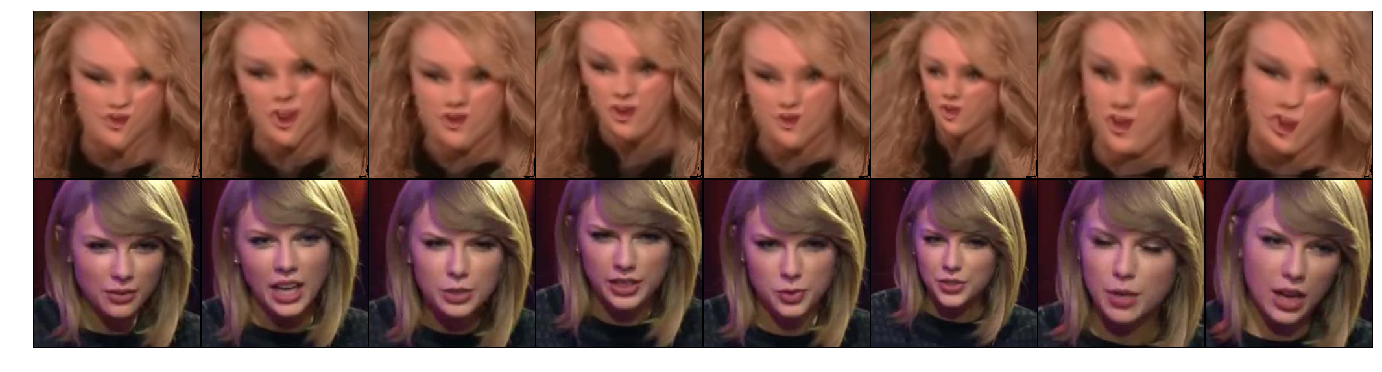

In [8]:
# Driving the source image with the driving sequence
source_images = []
for img in source_imgs:
    source_images.append(load_img(img).unsqueeze(0).repeat(len(driver_imgs), 1, 1, 1))
    
driver_images = None
for img in driver_imgs:
    if driver_images is None:
        driver_images = load_img(img).unsqueeze(0)
    else:
        driver_images = torch.cat((driver_images, load_img(img).unsqueeze(0)), 0)

# Run the model for each
result = run_batch(source_images, driver_images)
result = result.clamp(min=0, max=1)
img = torchvision.utils.make_grid(result.cpu().data)
    
# Visualise the results
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 24.
fig_size[1] = 24.
plt.rcParams["figure.figsize"] = fig_size
plt.axis('off')

result_images = img.permute(1,2,0).numpy()
driving_images = torchvision.utils.make_grid(driver_images.cpu().data).permute(1,2,0).numpy()
print("The results is: ")
plt.imshow(np.vstack((result_images, driving_images)))

**Code for using the dragon tattoo to modify the unwrapped mosaic**

The tattoo: 


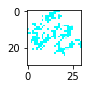

In [9]:
# Generate the dragon tattoo
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 1.
fig_size[1] = 1.
plt.rcParams["figure.figsize"] = fig_size

tattoo = Image.open('./tattoos/dragon_tattoo.png')
tattoo = tattoo.resize((30,30), Image.BILINEAR).rotate(45).convert('RGBA')

b, g, r, a = tattoo.split()
tattoo = Image.merge("RGBA", (g, b, r, a))
tattoo_flipped = tattoo.transpose(Image.FLIP_LEFT_RIGHT)

tattoo = np.array(tattoo) / 256.
tattoo[:,:,[1,2]] = 1
tattoo_flipped = np.array(tattoo_flipped) / 256.
tattoo_flipped[:,:,[1,2]] = 1
print("The tattoo: ")
plt.imshow(tattoo)

# Add a flipped version to make a moustache
tattoo = torch.Tensor(tattoo)
tattoo_flipped = torch.Tensor(tattoo_flipped)
tattoo = tattoo.permute(2,0,1)
tattoo_flipped = tattoo_flipped.permute(2,0,1)

# Changes the colour
alpha = tattoo[3:4,:,:].to(device)
tattoo = tattoo[0:3,:,:].to(device)
alpha_flipped = tattoo_flipped[3:4,:,:].to(device)
tattoo_flipped = tattoo_flipped[0:3,:,:].to(device)

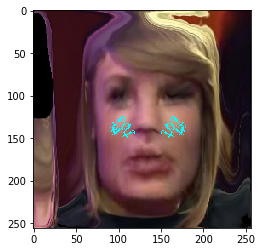

In [10]:
# Reload driving / source frames
driver_path = './examples/Taylor_Swift/1.6/nuBaabkzzzI/'
source_path = './examples/Taylor_Swift/1.6/nuBaabkzzzI/'

driver_imgs = [driver_path + d for d in sorted(os.listdir(driver_path))][0:8] # 8 driving frames
source_imgs  = [source_path + d for d in sorted(os.listdir(source_path))][0:1] # 1 source frames

source_images = []
for img in source_imgs:
    source_images.append(load_img(img).unsqueeze(0))
    
driver_images = None
for img in driver_imgs:
    if driver_images is None:
        driver_images = load_img(img).unsqueeze(0)
    else:
        driver_images = torch.cat((driver_images, load_img(img).unsqueeze(0)), 0)

        
# Modify the face with the given tattoo 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 4.
fig_size[1] = 4.
plt.rcParams["figure.figsize"] = fig_size

# Get the unwrapped face
sampler = model.pix2pixUnwrapped(*source_images)[0][:,0:2,:,:]
xs = np.linspace(-1,1,256)
xs = np.meshgrid(xs, xs)  
xs = np.stack(xs, 2) 
xs = torch.Tensor(xs).unsqueeze(0).repeat(1, 1,1,1).to(device)
sampler = nn.Tanh()(sampler).permute(0,2,3,1) + Variable(xs, requires_grad=False)

# Visualise unwrapped face with tattoo
result = nn.functional.grid_sample(source_images[0],  sampler).squeeze().cpu()
alpha = alpha.cpu()
tattoo = tattoo.cpu()
to_copy = tattoo * alpha.float() + (1 - alpha.float()) * result[:,125:155,90:120].data.cpu()
to_copy = Variable(to_copy).to(device)
result[:,125:155,90:120] = to_copy

alpha_flipped = alpha_flipped.cpu()
tattoo_flipped = tattoo_flipped.cpu()
to_copy = tattoo_flipped * alpha_flipped.float() + (1 - alpha_flipped.float()) * result[:,125:155,150:180].data.cpu()
to_copy = Variable(to_copy).to(device)
result[:,125:155,150:180] = to_copy
plt.imshow(result.data.squeeze().cpu().permute(1,2,0).numpy())

The unwrapped mosaic driven with the given face is: 


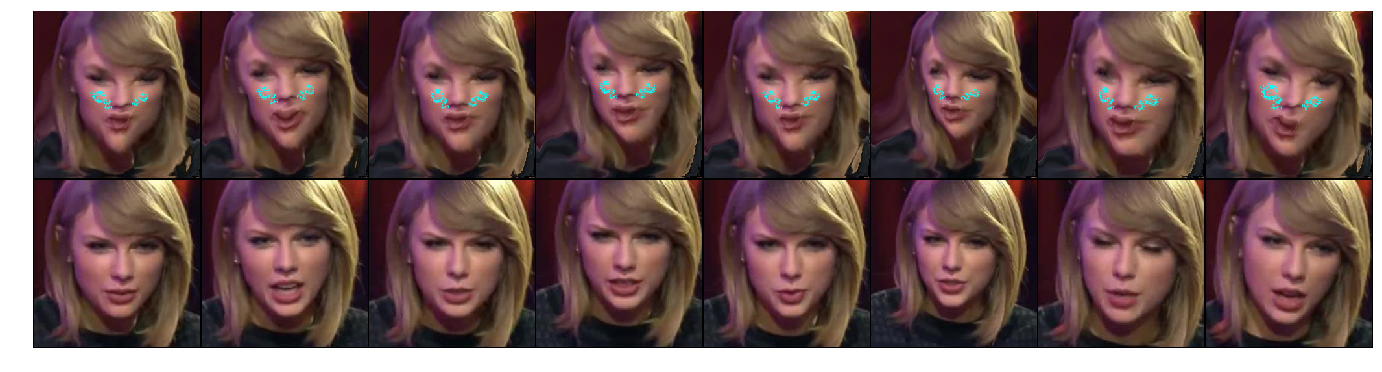

In [11]:
# Run the model for each
output_sampler = model.pix2pixSampler(driver_images)[0]
output_sampler = nn.Tanh()(output_sampler).permute(0,2,3,1) + Variable(xs, requires_grad=False)
result = nn.functional.grid_sample(result.unsqueeze(0).repeat(output_sampler.size(0), 1, 1, 1), 
                                       output_sampler.cpu()).squeeze()
    
result = result.clamp(min=0, max=1)
img = torchvision.utils.make_grid(result.cpu().data)
    
# Visualise the results
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 24.
fig_size[1] = 24.
plt.rcParams["figure.figsize"] = fig_size
plt.axis('off')

result_images = img.permute(1,2,0).numpy()
driving_images = torchvision.utils.make_grid(driver_images.cpu().data).permute(1,2,0).numpy()
print("The unwrapped mosaic driven with the given face is: ")
plt.imshow(np.vstack((result_images, driving_images)))

**Code for using the Harry Potter scar to modify the unwrapped mosaic**

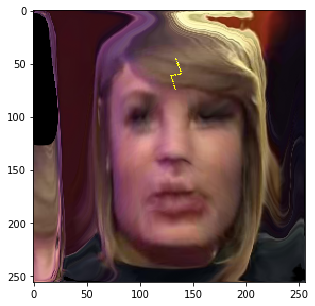

In [12]:
# Generat the tattoo for the hp scar
index = 7
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 1.
fig_size[1] = 1.
plt.rcParams["figure.figsize"] = fig_size
from PIL import Image
tattoo = Image.open('./tattoos/hp_scar_2.png')
tattoo = tattoo.resize((30,30), Image.BILINEAR).rotate(45).convert('RGBA')
b, g, r, a = tattoo.split()
tattoo = Image.merge("RGBA", (g, b, r, a))

tattoo = np.array(tattoo) / 256.
tattoo[:,:,[0,1]] = 1
tattoo = torch.Tensor(tattoo)
tattoo = tattoo.permute(2,0,1)
alpha = tattoo[2,:,:] < 0.9
tattoo = tattoo[0:3,:,:]

# Graph the result concatenated with the original frame across a sequence of frames : does the expression change?
# Match the 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 4.
fig_size[1] = 4.
plt.rcParams["figure.figsize"] = (5,5)

# Get the unwrapped face
sampler = model.pix2pixUnwrapped(*source_images)[0][:,0:2,:,:]
xs = np.linspace(-1,1,256)
xs = np.meshgrid(xs, xs)  
xs = np.stack(xs, 2) 
xs = torch.Tensor(xs).unsqueeze(0).repeat(1, 1,1,1).to(device)
sampler = nn.Tanh()(sampler).permute(0,2,3,1) + Variable(xs, requires_grad=False)
result = nn.functional.grid_sample(source_images[0],  sampler).squeeze()

alpha = alpha.float().clamp(max=1.0) # modify to make more/less realistic
to_copy = tattoo * alpha.float() + (1 - alpha.float()) * result[:,45:75,120:150].data.cpu()
to_copy = Variable(to_copy).to(device)
result[:,45:75,120:150] = to_copy
plt.imshow(result.data.squeeze().cpu().permute(1,2,0).numpy())

The unwrapped mosaic driven with the given face is: 


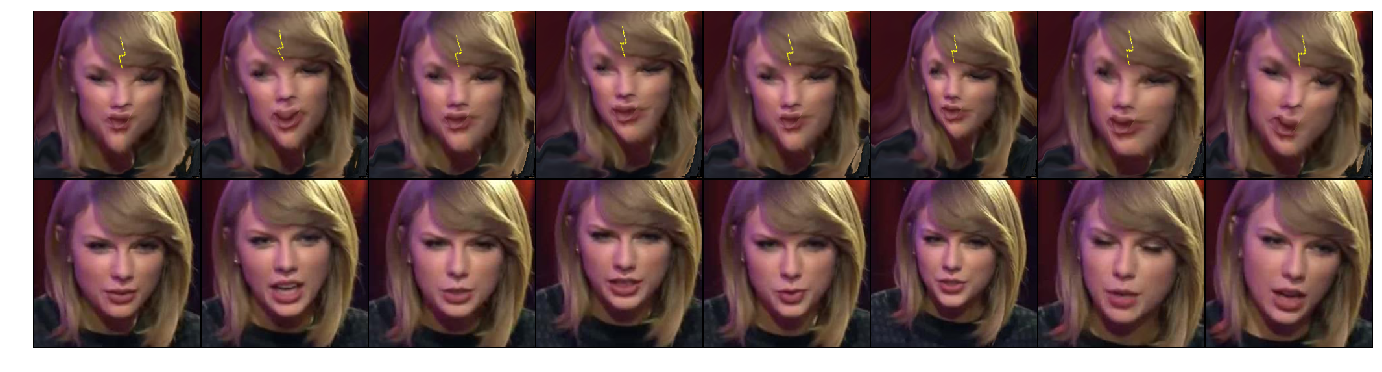

In [13]:
# Run the model for each
output_sampler = model.pix2pixSampler(driver_images)[0]
output_sampler = nn.Tanh()(output_sampler).permute(0,2,3,1) + Variable(xs, requires_grad=False)
result = nn.functional.grid_sample(result.unsqueeze(0).repeat(output_sampler.size(0), 1, 1, 1).cpu(), 
                                       output_sampler.cpu()).squeeze()
    
result = result.clamp(min=0, max=1)
img = torchvision.utils.make_grid(result.cpu().data)
    
# Visualise the results
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 24.
fig_size[1] = 24.
plt.rcParams["figure.figsize"] = fig_size
plt.axis('off')

result_images = img.permute(1,2,0).numpy()
driving_images = torchvision.utils.make_grid(driver_images.cpu().data).permute(1,2,0).numpy()
print("The unwrapped mosaic driven with the given face is: ")
plt.imshow(np.vstack((result_images, driving_images)))